<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Reformat-for-Florida-USGS" data-toc-modified-id="Reformat-for-Florida-USGS-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Reformat for Florida USGS</a></span><ul class="toc-item"><li><span><a href="#NoData-mask" data-toc-modified-id="NoData-mask-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>NoData mask</a></span></li><li><span><a href="#Solar-Zenith-Angles" data-toc-modified-id="Solar-Zenith-Angles-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Solar Zenith Angles</a></span></li><li><span><a href="#Pixel-index" data-toc-modified-id="Pixel-index-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Pixel index</a></span></li><li><span><a href="#(Potentially-useful-code)" data-toc-modified-id="(Potentially-useful-code)-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>(Potentially useful code)</a></span></li><li><span><a href="#Write-text-outputs" data-toc-modified-id="Write-text-outputs-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Write text outputs</a></span></li></ul></li><li><span><a href="#Albedo" data-toc-modified-id="Albedo-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Albedo</a></span></li></ul></div>

# Results
## Reformat for Florida USGS
*Write to text file structure required by the Florida USGS evapotranspiration model.*

Glob for the result dataset(s) and print the header for one of them:

In [1]:
import glob
import matplotlib.pyplot as plt

import warnings; warnings.filterwarnings('ignore')
sort2 = lambda ls: sorted(ls, key=lambda x: int(x.split("_")[-1][:-3]))

bsa_result = sort2(glob.glob("result/black_albedo*.nc"))
wsa_result = sort2(glob.glob("result/white_albedo*.nc"))
alb_result = sort2(glob.glob("result/blue_albedo*.nc"))

print("Black sky albedo outputs for 2018:"); bsa_result

Black sky albedo outputs for 2018:


['result/black_albedo_MCD43A1.2018_1.nc',
 'result/black_albedo_MCD43A1.2018_2.nc',
 'result/black_albedo_MCD43A1.2018_3.nc',
 'result/black_albedo_MCD43A1.2018_4.nc',
 'result/black_albedo_MCD43A1.2018_5.nc',
 'result/black_albedo_MCD43A1.2018_6.nc',
 'result/black_albedo_MCD43A1.2018_7.nc',
 'result/black_albedo_MCD43A1.2018_8.nc',
 'result/black_albedo_MCD43A1.2018_9.nc',
 'result/black_albedo_MCD43A1.2018_10.nc',
 'result/black_albedo_MCD43A1.2018_11.nc',
 'result/black_albedo_MCD43A1.2018_12.nc']

Read the twelve black sky albedo netCDFs as a multidataset and print the header:

In [2]:
import xarray as xr
import pandas as pd
import numpy as np
np.set_printoptions(suppress=True)

ds = xr.open_dataset(bsa_result[0])

### NoData mask
Make an array of booleans that represent masked pixels by reading the first timestep of the input dataset and checking for `np.nan`:

In [3]:
# temporarily open the input dataset that we processed previously
with xr.open_dataset("data/MCD43A1.2018.nc") as tmp:
    
    # select timestep 1 of band 1 of the input dataset
    tmp_array = tmp["BRDF_Albedo_Parameters_Band1"][0].sel(Num_Parameters=0)
    
    # get the inverse of the boolean array of invalid pixels
    mask_array = np.logical_not(np.isnan(tmp_array.data))

mask_array

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

Make an `xarray.DataArray` for the mask and add it to the results dataset:

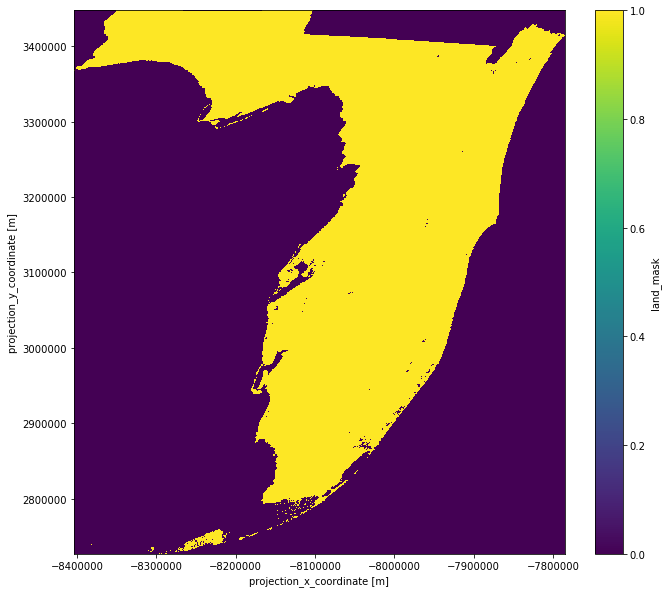

In [4]:
%matplotlib inline

ds.coords["land_mask"] = xr.DataArray(
    data=mask_array,
    coords=[ds.y, ds.x],
    dims=["y", "x"],
    attrs=dict(
        grid_mapping="crs", 
        flag_values="0 1", 
        flag_meanings="nodata data"))

ds.coords["land_mask"].plot(x="x", y="y", figsize=(11,10))

### Solar Zenith Angles

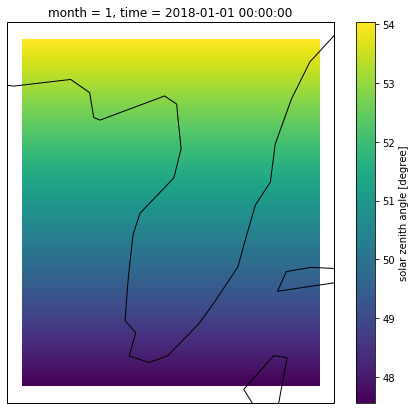

In [5]:
import cartopy.crs as ccrs

sinu = ccrs.Sinusoidal(
    central_longitude=ds.crs.longitude_of_central_meridian, 
    false_northing=ds.crs.false_northing, 
    false_easting=ds.crs.false_northing, 
    globe=None)

fig = plt.figure(figsize=(8,7))
ax = plt.axes(projection=sinu)
ds["solar_zenith_angle"][0].plot(ax=ax)
ax.coastlines()

### Pixel index

Make an array of index values for the permuted xy arrays. The evapotranspiration model takes inputs that sequence in column-major order:
```
 1  24.249  -79.398  0.000 0.000 0.000 ... 
 2  24.266  -79.398  0.000 0.000 0.000 ...
 3  24.284  -79.398  0.000 0.000 0.000 ...
 4  24.302  -79.398  0.000 0.000 0.000 ...  
```

But `xarray`'s mappings are more convenient. So, reshape the index array using the shape of longitude array in the results dataset:

### (Potentially useful code)

Coordinate array for `xyindex`:
```python
xyindex = np.array(list(range(ds.x.size*ds.y.size)))    # seq 1 to npixels
xyindex = xyindex.reshape(ds.lon.shape)                 # reshape with lon

ds.coords["xyindex"] = xr.DataArray(
    data=xyindex,
    coords=[ds.y, ds.x],
    dims=["y", "x"])

ds["xyindex"].plot(x="x", y="y", figsize=(6,5))
```

Dask piping:
```python
df = dd.from_pandas(pd.DataFrame(load_boston().data),npartitions=10)

def operation(df):
   df['new'] = df[0]
   return(df[['new']])

df.pipe(operation).to_csv('boston*.csv')
```

Simple progress widget:
```python
import time, sys
from IPython.display import clear_output

def update_progress(progress, nbar=20):
    """Simple ASCII progress bar for Jupyter environment."""
    
    if isinstance(progress, int): 
        progress = float(progress)
    if not isinstance(progress, float): 
        progress = 0
    if progress < 0: 
        progress = 0
    if progress >= 1: 
        progress = 1
    block = int(round(nbar*progress))
    
    clear_output(wait = True)
    prog = "Progress: [{0}] {1:.1f}%"
    print(prog.format("#"*block+"-"*(nbar-block), progress*100))
```

### Write text outputs

Now write each valid pixel's time series to output text files. We'll concatenate them column-wise in shell script. This could take a while so import the progress bar from dask. 

The for loop below is iterating over the output netCDF files and reformatting as text files where columns are timesteps and rows are pixels:

In [ ]:
from dask.diagnostics import ProgressBar


for f in (bsa_result + wsa_result + alb_result):
    print(f)
    
    # make a numpy array to serve as pixel index
    xyi = np.array(list(range(ds.x.size*ds.y.size)))

    # reshape band data to match USGS model requirement
    b1 = ds["BRDF_Albedo_Parameters_Band1"]

    # reshape continue
    b1stack = b1.stack(xy=("x","y"))
    b1flat = b1stack.reset_index(["xy"])
    b1flat.coords["xy"] = xr.DataArray(data=xyi, dims=["xy"])
    b1tflat = b1flat.T

    # convert to dask dataframe
    b1srt_ddf = b1tflat.to_dataset().to_dask_dataframe()
    
    out = f[:-3]+"-*.dat"
    with ProgressBar():
        
        b1srt_ddf = b1srt_ddf[b1srt_ddf.land_mask]
        b1srt_ddf = b1srt_ddf.categorize(columns=['time'])
        
        b1srt_ddf.pivot_table(
            values='BRDF_Albedo_Parameters_Band1', 
            index='xy', 
            columns='time'
        ).to_csv(out, sep="\t")

    #timeseries = None         # discard objects

result/black_albedo_MCD43A1.2018_1.nc
[########################################] | 100% Completed | 14.1s
[################################        ] | 81% Completed | 22min 17.6s

**THIS LOOP IS TOO SLOW**
Loop over pixels and write valid data to text file:

In [ ]:
npixel = 0

tmpds = ds["BRDF_Albedo_Parameters_Band1"]

# open output table for writing
with open("result/band1_black_2018.dat", "w") as f:
    
    # iterate over rows
    for i in range(0, tmpds.y.size):
        
        # iterate over columns
        for j in range(0, tmpds.x.size):
        
            # select pixel
            tmp = tmpds.isel(x=i, y=j)
            
            # if mask value == True (valid data)
            if tmp.coords["mask"]:
                
                # join row items with tabs and write
                f.write("\t".join([
                    str(npixel),
                    str(tmp.lat.data),
                    str(tmp.lon.data),
                    "\t".join([str(v) for v in tmp.data])]) + "\n")
            
            # update progress bar
            update_progress((i * tmpds.y.size + j) / tmpds.xyindex.size)

update_progress(1) # done

## Albedo

In [ ]:
t = ds["BRDF_Albedo_Parameters_Band1"].groupby("time.month").mean("time")
t